# Primera Práctica

Alejandro Jesús González Santana y Joaquín Ibáñez Peñalva

## Importar librerías

In [5]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Definición de Red

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        for param in self.base_model.layer4.parameters():
            param.requires_grad = True
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.base_model(x)

## Cálculo de métricas

In [7]:
def calculate_metrics(loader, model):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = 100 * sum([1 for true, pred in zip(y_true, y_pred) if true == pred]) / len(y_true)
    return accuracy, cm, f1, recall


## Entrenamiento de Red

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='photos/real_and_fake_face', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    net.eval()
    train_accuracy, train_cm, train_f1, train_recall = calculate_metrics(train_loader, net)
    test_accuracy, test_cm, test_f1, test_recall = calculate_metrics(test_loader, net)
    losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    print(f"Train Accuracy: {train_accuracy}%, Confusion Matrix:\n{train_cm}, F1 Score: {train_f1}, Recall: {train_recall}")
    print(f"Test Accuracy: {test_accuracy}%, Confusion Matrix:\n{test_cm}, F1 Score: {test_f1}, Recall: {test_recall}")

print('Finished Training')


Usando cuda para entrenar


c:\ProgramData\miniconda3\envs\nuevo_AA2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\nuevo_AA2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7028064494039498
Train Accuracy: 61.51960784313726%, Confusion Matrix:
[[624 135]
 [493 380]], F1 Score: 0.6022871544850036, Recall: 0.6151960784313726
Test Accuracy: 58.43520782396088%, Confusion Matrix:
[[168  33]
 [137  71]], F1 Score: 0.5577922308016918, Recall: 0.5843520782396088
Epoch 2, Loss: 0.6366444697567061
Train Accuracy: 66.4828431372549%, Confusion Matrix:
[[365 394]
 [153 720]], F1 Score: 0.6535272510875715, Recall: 0.664828431372549
Test Accuracy: 60.391198044009776%, Confusion Matrix:
[[ 90 111]
 [ 51 157]], F1 Score: 0.5941309479653397, Recall: 0.6039119804400978
Epoch 3, Loss: 0.620487616927016
Train Accuracy: 70.09803921568627%, Confusion Matrix:
[[403 356]
 [132 741]], F1 Score: 0.6920993509793, Recall: 0.7009803921568627
Test Accuracy: 63.56968215158924%, Confusion Matrix:
[[ 95 106]
 [ 43 165]], F1 Score: 0.6258029483588425, Recall: 0.6356968215158925
Epoch 4, Loss: 0.5642180179848391
Train Accuracy: 71.56862745098039%, Confusion Matrix:
[[584 17

## Gráficas de medidas

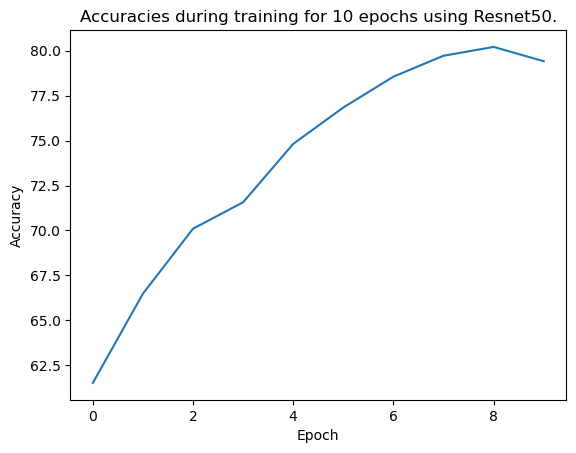

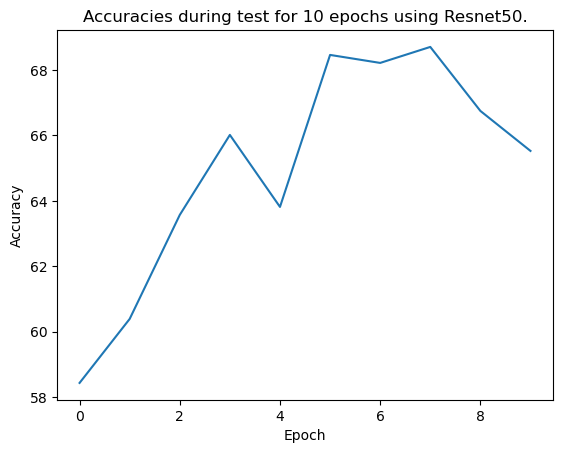

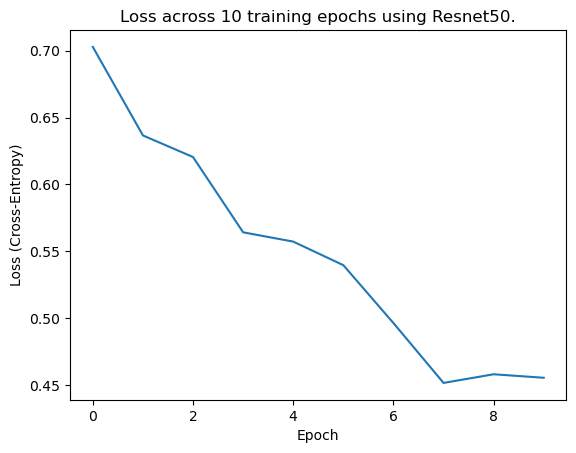

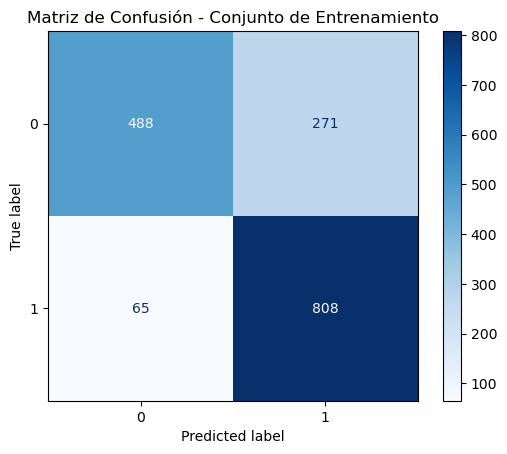

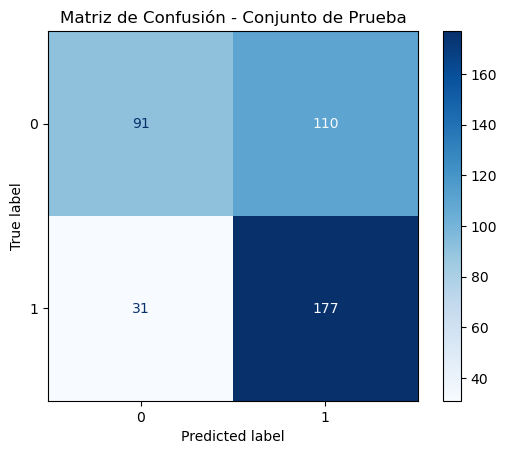

In [14]:
import matplotlib.pyplot as plt

classes = dataset.classes

plt.plot(train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracies during training for 10 epochs using Resnet50.")
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracies during test for 10 epochs using Resnet50.")
plt.show()

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.title("Loss across 10 training epochs using Resnet50.")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=classes)
ax = plt.gca()
ax.set_title("Matriz de Confusión - Conjunto de Entrenamiento")
disp.plot(ax=ax, values_format='d', cmap='Blues')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=classes)
ax = plt.gca()
ax.set_title("Matriz de Confusión - Conjunto de Prueba")
disp.plot(ax=ax, values_format='d', cmap='Blues')
plt.show()
